In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

from sklearn.model_selection import train_test_split

# Load data

In [2]:
path = '/home/alexkay/NLP.Penn/task2_data/data2_ex.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,class,tweet
0,0,0,"depression hurts, cymbalta can help"
1,5,0,"@jessicama20045 right, but cipro can make thin..."
2,6,0,@fibby1123 are you on paxil .. i need help
3,7,0,@redicine the lamotrigine and sjs just made ch...
4,8,0,have decided to skip my #humira shot today. my...
...,...,...,...
21376,21703,0,rt @15stephen15: #todolist 1-finish throat loz...
21377,21704,0,me: how is your depression now that you�re on ...
21378,21705,1,rt @ianibbo: finding out i'm allergic to fluox...
21379,21706,0,@theantimyth @crossfitchemist unexpected and p...


In [3]:
df_0 = df[df['class']==0][:2500]
df_1 = df[df['class']==1][:2500]

df = pd.concat([df_0, df_1])

In [4]:
print(df.shape)
data = df[['tweet', 'class']]
data.head()

(5000, 3)


,tweet,class
0,"depression hurts, cymbalta can help",0
1,"@jessicama20045 right, but cipro can make thin...",0
2,@fibby1123 are you on paxil .. i need help,0
3,@redicine the lamotrigine and sjs just made ch...,0
4,have decided to skip my #humira shot today. my...,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['class'], test_size=0.15, random_state=5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4250,), (4250,), (750,), (750,))

# Tokenize data

In [6]:
num_words = 10_000

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, 
                                                  oov_token='<OOV>', 
                                                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

In [8]:
tokenizer.fit_on_texts(X_train)

In [9]:
word_index = tokenizer.word_index

In [10]:
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

In [11]:
max_len1 = max([len(el) for el in x_train])
max_len2 = max([len(el) for el in x_test])
max_len = max(max_len1, max_len2)
max_len

33

In [12]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len, padding='post')

In [13]:
x_train, x_test

(array([[2523,    2,   19, ...,    0,    0,    0],
        [ 226,   12,    3, ...,    0,    0,    0],
        [  37, 1559,   12, ...,    0,    0,    0],
        ...,
        [3420,  235,  156, ...,    0,    0,    0],
        [  18,   98,    5, ...,    0,    0,    0],
        [   2,   82,   28, ...,    0,    0,    0]], dtype=int32),
 array([[6230,  241,   36, ...,    0,    0,    0],
        [  33,   47,  295, ...,    0,    0,    0],
        [  36,  180,  347, ...,    0,    0,    0],
        ...,
        [   1, 1003, 1722, ...,    0,    0,    0],
        [   1,   22,  885, ...,    0,    0,    0],
        [ 172,  190,  163, ...,    0,    0,    0]], dtype=int32))

In [14]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [15]:
y_train.shape, y_test.shape

((4250, 2), (750, 2))

In [16]:
BATCH_SIZE = 128
BUF_SIZE = 2000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUF_SIZE).padded_batch(
                                                                            BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).padded_batch(
                                                                            BATCH_SIZE, drop_remainder=True)

In [17]:
train_dataset, test_dataset

(<PaddedBatchDataset shapes: ((128, 33), (128, 2)), types: (tf.int32, tf.float32)>,
 <PaddedBatchDataset shapes: ((128, 33), (128, 2)), types: (tf.int32, tf.float32)>)

# Prepare embedding with fasttext

In [18]:
from gensim.models.fasttext import FastText 
from gensim.test.utils import datapath

In [19]:
#del model_gensim, model

In [20]:
corpus_file = datapath(path)

In [21]:
vec_size = 100

In [22]:
model = FastText(size=vec_size)

In [23]:
model.build_vocab(corpus_file=corpus_file)

In [24]:
model.train(
    corpus_file=corpus_file, 
    epochs=10,
    total_examples=model.corpus_count, 
    total_words=model.corpus_total_words,
    model='CBOW',
    min_count=3
)

In [25]:
vocab_size = len(tokenizer.word_index)
vocab_size, num_words

(10765, 10000)

In [26]:
embedding_matrix = np.zeros((num_words, vec_size))
embedding_matrix.shape

(10000, 100)

In [27]:
for i, word in enumerate(tokenizer.word_index):
    if i == num_words: break
    embedding_matrix[i] = model[word]
    
embedding_matrix.shape, model['<OOV>'].shape

/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


((10000, 100), (100,))

# Model

In [28]:
num_words = num_words
embedding_dim = vec_size
units = 64
BATCH_SIZE = BATCH_SIZE
patience = 5
EPOCHS = 40
lr = 1e-4

rate_drop_lstm  = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

if model:
    del model
    
def build_model(num_words, embedding_dim, units, batch_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(num_words, 
                                  embedding_dim, 
                                  #batch_input_shape=[BATCH_SIZE, max_len],
                                  weights=[embedding_matrix],
                                  trainable=True),
        tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(64, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model


model = build_model(num_words, embedding_dim, units, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [29]:
#https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change
import tensorflow_addons as tfa
model.compile(loss=tf.keras.losses.BinaryCrossentropy(name='BC_loss'),
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics=tfa.metrics.F1Score(2))

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [31]:
history = model.fit(train_dataset, 
                    validation_data=test_dataset, 
                    epochs=EPOCHS, 
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/40
33/33 [==============================] - 7s 197ms/step - loss: 0.6926 - f1_score: 0.5132 - val_loss: 0.6876 - val_f1_score: 0.5276
Epoch 2/40
33/33 [==============================] - 6s 187ms/step - loss: 0.6874 - f1_score: 0.5473 - val_loss: 0.6805 - val_f1_score: 0.5722
Epoch 3/40
33/33 [==============================] - 6s 188ms/step - loss: 0.6815 - f1_score: 0.5669 - val_loss: 0.6687 - val_f1_score: 0.6301
Epoch 4/40
33/33 [==============================] - 6s 183ms/step - loss: 0.6705 - f1_score: 0.6115 - val_loss: 0.6501 - val_f1_score: 0.6375
Epoch 5/40
33/33 [==============================] - 6s 189ms/step - loss: 0.6553 - f1_score: 0.6192 - val_loss: 0.6218 - val_f1_score: 0.6822
Epoch 6/40
33/33 [==============================] - 6s 185ms/step - loss: 0.6396 - f1_score: 0.6489 - val_loss: 0.6111 - val_f1_score: 0.6675
Epoch 7/40
33/33 [==============================] - 6s 189ms/step - loss: 0.6282 - f1_score: 0.6509 - val_loss: 0.6023 - val_f1_score: 0.6706
Epoch 

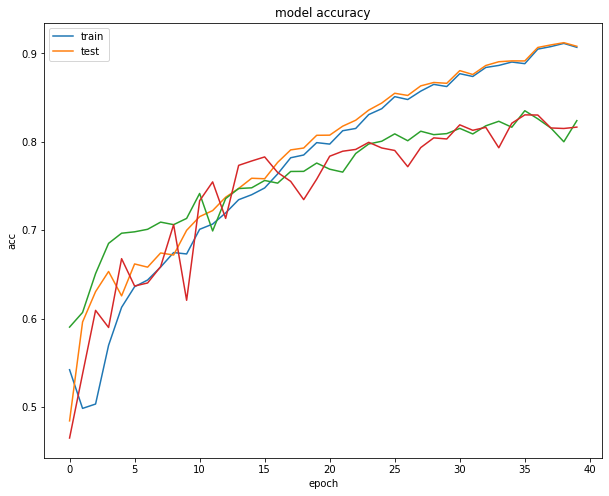

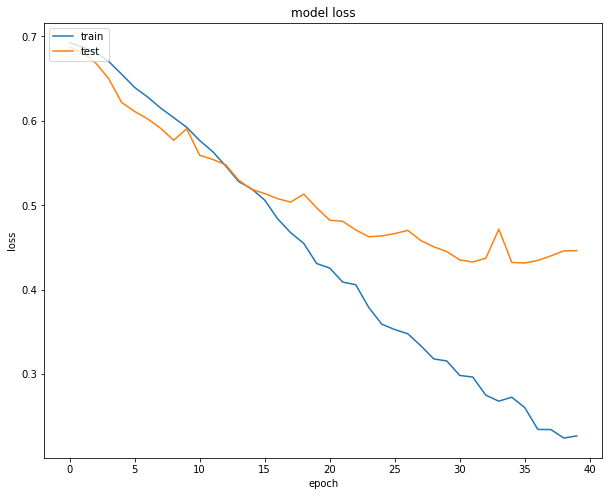

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 

# summarize history for accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()